In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree

import pandas as pd
import numpy as np
import pyodbc
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression, RANSACRegressor, Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import time
from sklearn import neural_network

import warnings
warnings.filterwarnings('ignore') 


from sqlalchemy import create_engine, event
from sqlalchemy.exc import IntegrityError
from pandas.tseries.offsets import MonthEnd


from sklearn import tree
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier     #big 99 / 56   #small 99 / 56
from sklearn.linear_model import LogisticRegression     #big 44 / 44 
from sklearn.ensemble import GradientBoostingClassifier #big 49 / 47
from sklearn.ensemble import BaggingClassifier          #big 98 / 56
from sklearn.ensemble import AdaBoostClassifier         #big 49 / 48


from sklearn.svm import SVC                            
import xgboost as xgb


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.patches as mpatches


папка_хранения_результатов=r'E:\Jupyter\ION'
os.chdir(папка_хранения_результатов)

In [38]:
# Для нейронки ILYA
%matplotlib inline 


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers import BatchNormalization


from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam

from keras.layers.advanced_activations import *
from keras.layers.convolutional import Convolution1D, MaxPooling1D #, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

# Количество классов
nb_classes = 11

#Выставляем размер для графиков
plt.rcParams["figure.figsize"] = (20,10)



In [39]:
test = pd.read_csv(r'E:\Jupyter\ION\test_clean.csv')
test['open_channels'] = 0
test['layer'] = 1
train = pd.read_csv(r'E:\Jupyter\ION\train_clean.csv')
train['layer'] = 0
train.head()

,time,signal,open_channels,layer
0,0.0001,-2.7600,0,0
1,0.0002,-2.8557,0,0
2,0.0003,-2.4074,0,0
3,0.0004,-3.1404,0,0
4,0.0005,-3.1525,0,0


In [40]:
ds=pd.concat([train])
ds=ds.set_index('time')
ds['open_channels']=ds['open_channels'].astype('int16')

ds['layer']=ds['layer'].astype('int16') #для экономии памяти
ds['signal']=ds['signal'].astype('float16') #для экономии памяти

ds[:5]

,signal,open_channels,layer
time,,,
0.0001,-2.759766,0,0
0.0002,-2.855469,0,0
0.0003,-2.408203,0,0
0.0004,-3.140625,0,0
0.0005,-3.152344,0,0
...,...,...,...
4.9996,-2.812500,0,0
4.9997,-2.378906,0,0
4.9998,-2.591797,0,0


In [41]:

#graf = ds.loc[ds.index[:], 'open_channels'].tolist()
#plt.plot(graf)
#plt.show()
#graf = ds.loc[ds.index[:], 'signal'].tolist()
#plt.plot(graf)
#plt.show()



In [42]:
train_set=ds[((ds.index>=200) & (ds.index<=250))]            
test_set=ds[((ds.index>=450) & (ds.index<=500))]


In [43]:
lag=30 # определяет число точек, поиграй с увеличением/ уменьшением числа
train_set[f'signal_{0}']=train_set['signal']
test_set[f'signal_{0}']=test_set['signal']

for i in range(1,lag):
    train_set[f'signal_{i}']=train_set['signal'].shift(periods=i)
    train_set[f'signal_{-i}']=train_set['signal'].shift(periods=-i)
    
for i in range(1,lag):
    test_set[f'signal_{i}']=test_set['signal'].shift(periods=i)
    test_set[f'signal_{-i}']=test_set['signal'].shift(periods=-i)
    
train_set=train_set.dropna()
test_set=test_set.dropna()

In [44]:
Y_train=train_set['open_channels']
Y_test=test_set['open_channels']

In [45]:
# Нормализуем для нейронки
Y_trainN=train_set['open_channels']
Y_testN=test_set['open_channels']

X_trainN=train_set.iloc[:,3:]/10
X_testN=test_set.iloc[:,3:]/10


#Преобразуем ответы в формат one hot encoding
from tensorflow.keras import utils


Y_trainN = utils.to_categorical(Y_trainN,11)
Y_testN  = utils.to_categorical(Y_testN,11)

Y_trainN = Y_trainN.astype('int16')
Y_testN  = Y_testN.astype('int16')



In [46]:
# Создаем нейронную сеть

model = Sequential()
model.add(Dense(64, input_dim=59, activation="relu"))

model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(11, activation="softmax"))


opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test10.hdf5", verbose=1, save_best_only=True)

#Загружаем предрасчитанные веса
#model.load_weights(r'E:\Jupyter\ION\test.hdf5')
                               
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])



print(model.summary())



# estimate accuracy on whole dataset using loaded weights
#scores = model.evaluate(X_testN, Y_testN, verbose=0)
#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                3840      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

In [47]:
# Обучаем 
history = model.fit(X_trainN, Y_trainN, 
          epochs = 20, 
          batch_size = 64, 
          verbose=1, 
          validation_data=(X_testN, Y_testN),
          #callbacks=[checkpointer],
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Epoch 1/20
7812/7812 [==============================] - 90s 11ms/step - loss: 0.7180 - accuracy: 0.7105 - val_loss: 0.3746 - val_accuracy: 0.8653

Epoch 00001: val_loss improved from inf to 0.37464, saving model to test10.hdf5
Epoch 2/20
7812/7812 [==============================] - 89s 11ms/step - loss: 0.4892 - accuracy: 0.8114 - val_loss: 0.3695 - val_accuracy: 0.8591

Epoch 00002: val_loss improved from 0.37464 to 0.36947, saving model to test10.hdf5
Epoch 3/20
7812/7812 [==============================] - 89s 11ms/step - loss: 0.4587 - accuracy: 0.8272 - val_loss: 0.3324 - val_accuracy: 0.8757

Epoch 00003: val_loss improved from 0.36947 to 0.33239, saving model to test10.hdf5
Epoch 4/20
7812/7812 [==============================] - 89s 11ms/step - loss: 0.4434 - accuracy: 0.8349 - val_loss: 0.3247 - val_accuracy: 0.8757

Epoch 00004: val_loss improved from 0.33239 to 0.32470, saving model to test10.hdf5
Epoch 5/20
7812/7812 [==============================] - 89s 11ms/step - loss: 0.

In [48]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(X_testN, Y_testN, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))


15624/15624 [==============================] - 34s 2ms/step - loss: 0.3293 - accuracy: 0.8721
Доля верных ответов на тестовых данных, в процентах: 87.2081


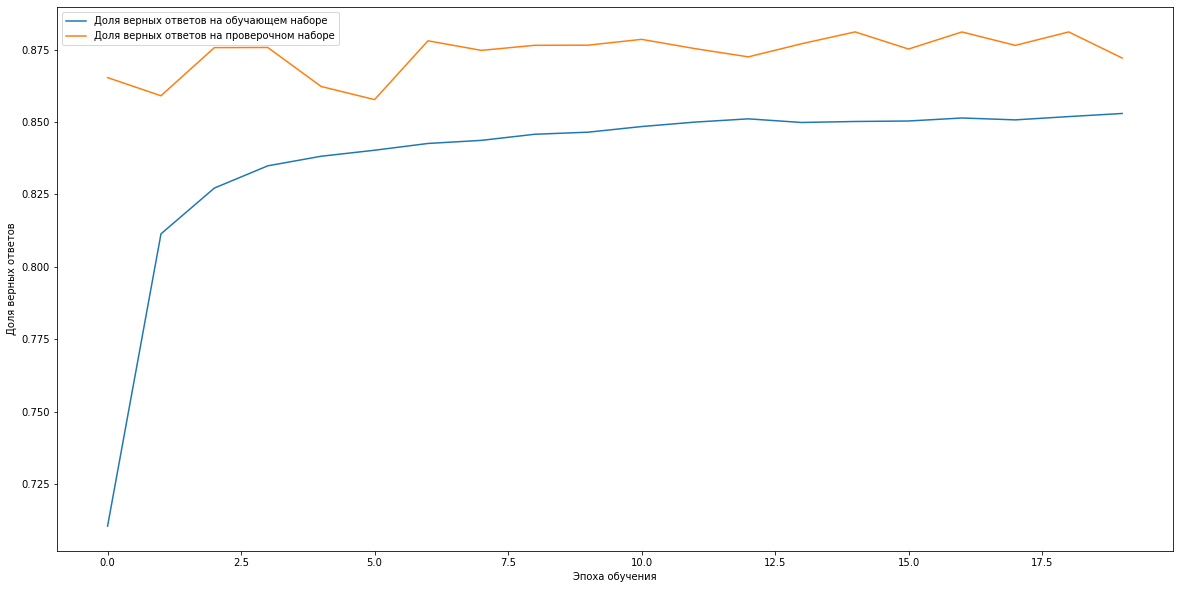

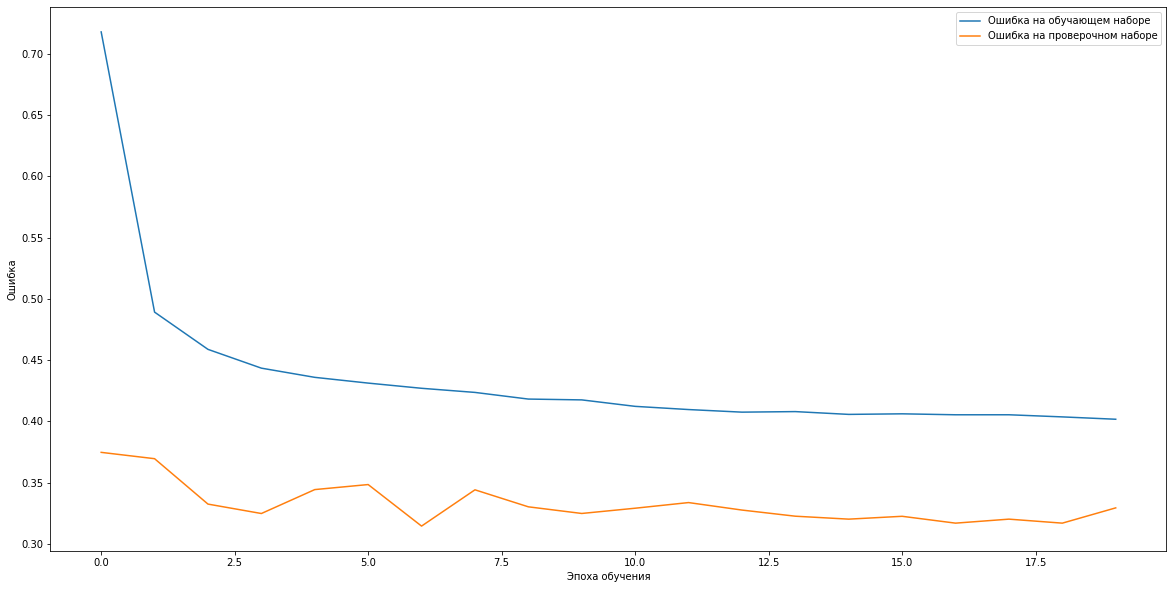

In [49]:
# График обучени
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [50]:
#Предсказываем
Y_predictNT=model.predict(X_testN)
#Выбор лучшего
Y_predictN=np.argmax(Y_predictNT, axis=1)
test_set['open_channels_pr']=Y_predictN
print('F1=',f1_score(Y_test,Y_predictN, average='macro')) #конкурсная оценка

F1= 0.761301042005898


In [26]:
model.save(r'E:\Jupyter\ION\my_model.h5')
#model = load_model('my_model.h5')

КОНЕЦ НЕЙРОНКЕ

In [51]:
clf=RandomForestClassifier(n_jobs=-1) # замени на нейронку

X_train=train_set.iloc[:,3:]
Y_train=train_set['open_channels']

X_test=test_set.iloc[:,3:]
Y_test=test_set['open_channels']

clf.fit(X_train, Y_train)


RandomForestClassifier(n_jobs=-1)

In [52]:
Y_predict=clf.predict(X_test)

ValueError: X has 60 features, but DecisionTreeClassifier is expecting 59 features as input.

In [17]:
test_set['open_channels_pr']=Y_predict

499943

In [134]:
print('F1=',f1_score(Y_test,Y_predict, average='macro')) #конкурсная оценка

F1= 0.7070065175147493


In [9]:
def рисовалка(ds):
    col=ds.columns

    #plt.rcParams["figure.figsize"] = (20,10)

    for it in range(11):

        samp=ds.iloc[500000*it:500000*(it+1)]

        samp_chn_time=[]
        samp_chn_sign=[]

        for open_chn in range (11):
            samp_chn_time.append(list(samp.loc[samp[col[2]]==open_chn,col[0]]))
            samp_chn_sign.append(list(samp.loc[samp[col[2]]==open_chn,col[1]]))

        plt.plot(samp_chn_time[0], samp_chn_sign[0],'r.',linestyle="None",label='0')

        plt.plot(samp_chn_time[1],samp_chn_sign[1],"g.",linestyle="None",label='1')

        plt.plot(samp_chn_time[2],samp_chn_sign[2],"b.",linestyle="None",label='2')

        plt.plot(samp_chn_time[3],samp_chn_sign[3],'tab:orange',marker=".",linestyle="None",label='3')

        plt.plot(samp_chn_time[4],samp_chn_sign[4],"y.",linestyle="None",label='4')

        plt.plot(samp_chn_time[5], samp_chn_sign[5],"m.",linestyle="None",label='5')

        plt.plot(samp_chn_time[6],samp_chn_sign[6],"k.",linestyle="None",label='6')

        plt.plot(samp_chn_time[7],samp_chn_sign[7],"c.",linestyle="None",label='7')

        plt.plot(samp_chn_time[8],samp_chn_sign[8],'tab:gray',marker=".",linestyle="None",label='8')

        plt.plot(samp_chn_time[9],samp_chn_sign[9],"tab:brown",marker=".",linestyle="None",label='9')

        plt.plot(samp_chn_time[10],samp_chn_sign[10],"tab:purple",marker=".",linestyle="None",label='10')

    #     plt.legend([chnl_0, chnl_1,chnl_2,chnl_3,chnl_4,chnl_5,chnl_6,chnl_7,chnl_8,chnl_9,chnl_10], 
    #                ["0",'1', '2',"3","4","5","6","7","8","9","10"])


        red_patch = mpatches.Patch(color='red', label='0')
        green_patch = mpatches.Patch(color='green', label='1')
        blue_patch = mpatches.Patch(color='blue', label='2')
        orang_patch = mpatches.Patch(color='orange', label='3')
        yel_patch = mpatches.Patch(color='yellow', label='4')
        mag_patch = mpatches.Patch(color='magenta', label='5')
        blc_patch = mpatches.Patch(color='black', label='6')
        cyan_patch = mpatches.Patch(color='cyan', label='7')
        gray_patch = mpatches.Patch(color='gray', label='8')
        brwn_patch = mpatches.Patch(color='brown', label='9')
        purp_patch = mpatches.Patch(color='purple', label='10')


        plt.legend(handles=[red_patch,green_patch,blue_patch,orang_patch,yel_patch,
                           mag_patch,blc_patch,cyan_patch,gray_patch,brwn_patch,purp_patch])


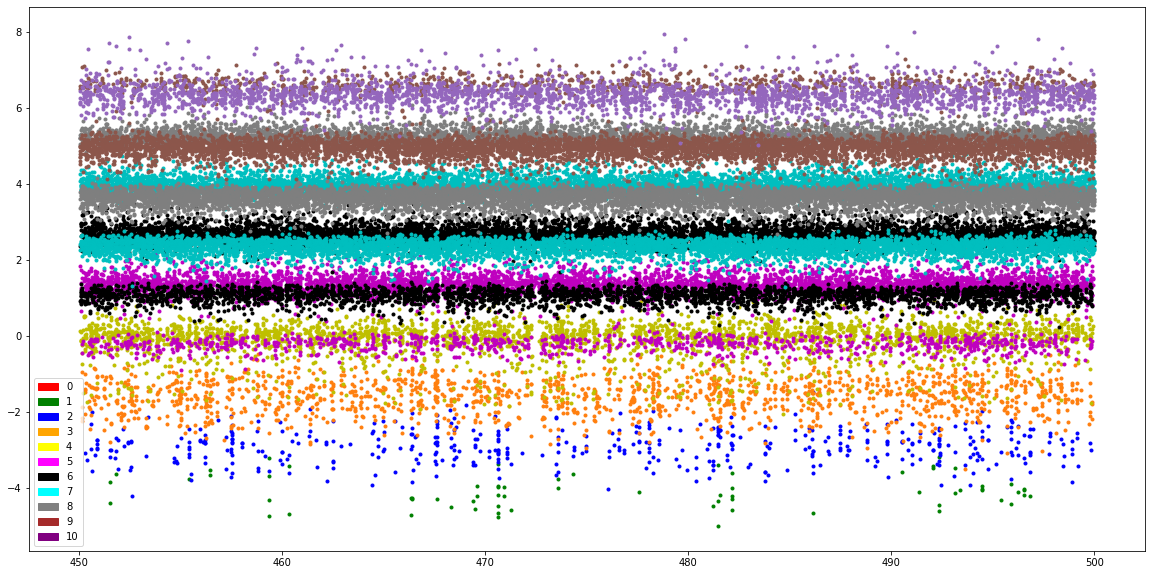

In [10]:
#отрисовка ошибочных
dss=test_set[test_set.open_channels!=test_set.open_channels_pr]
рисовалка(dss.reset_index()[['time','signal','open_channels']])


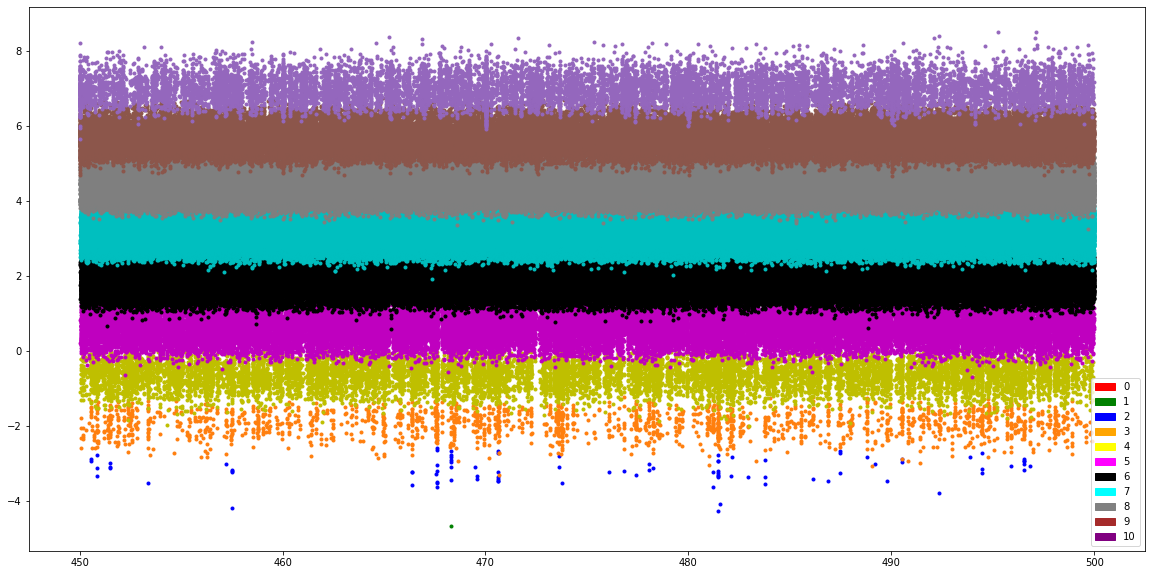

In [11]:
#отрисовка правильных
dss=test_set[test_set.open_channels==test_set.open_channels_pr]
рисовалка(dss.reset_index()[['time','signal','open_channels']])